## ch15 Model Evaluation
- https://github.com/mattharrison/effective_xgboost_book/blob/main/xgbcode.ipynb

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.8.4</div>
<div style="text-align: right"> Last update: 2023.8.4</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

새롭게 라이브러리를 로드 하자.

In [2]:
import dtreeviz
from feature_engine import encoding, imputation
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, \
    metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier

import urllib
import zipfile

import xg_helpers as xhelp
from xg_helpers import my_dot_export

In [3]:
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

In [4]:
raw = xhelp.extract_zip(url, fname, member_name)
## Create raw X and raw y
kag_X, kag_y = xhelp.get_rawX_y(raw, 'Q6')

In [5]:
## Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
model_selection.train_test_split(
kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)

In [6]:
## Transform X with pipeline
X_train = xhelp.kag_pl.fit_transform(kag_X_train)
X_test = xhelp.kag_pl.transform(kag_X_test)
## Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)
# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

In [7]:
X.head()

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat
587,25,18.0,4.0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0
3065,22,16.0,1.0,10000,1,0,0,1,0,0,0,0,1,0,1,0,0,0
8435,22,18.0,1.0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
3110,40,20.0,3.0,125000,1,0,1,0,1,0,0,1,0,0,0,1,0,0
16372,45,12.0,5.0,100000,1,0,1,1,0,0,0,1,0,0,0,1,0,0


In [8]:
y.head()

587      1
3065     0
8435     0
3110     0
16372    1
dtype: int64

### 15.1 Accuracy

In [9]:
xgb_def = xgb.XGBClassifier()
xgb_def.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [10]:
xgb_def.score(X_test, y_test)

0.7458563535911602

In [11]:
from sklearn import metrics

metrics.accuracy_score(y_test, xgb_def.predict(X_test))

0.7458563535911602

- 성능이 74% 정도이다. 하지만 class imbalance 상태일 때는 더 따져봐야 한다.

### 15.2 Confusion Matrix

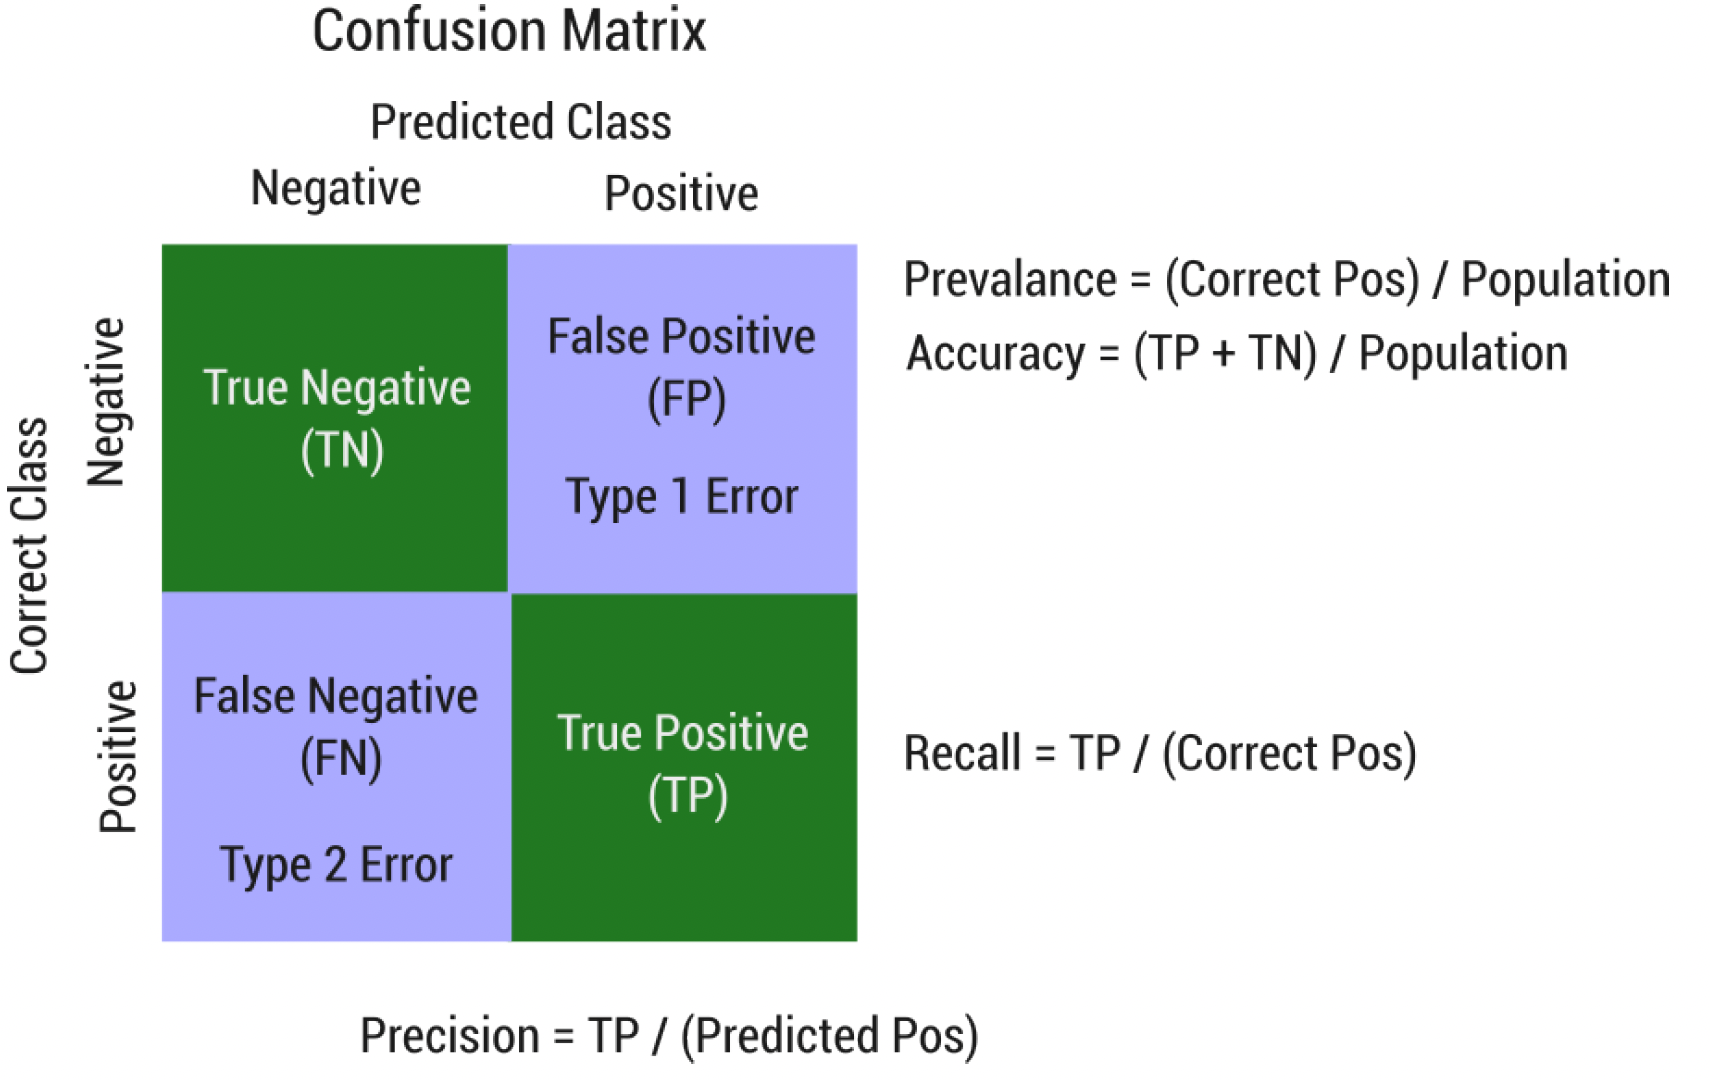

yellowbrick으로 매트릭스를 그려보자.

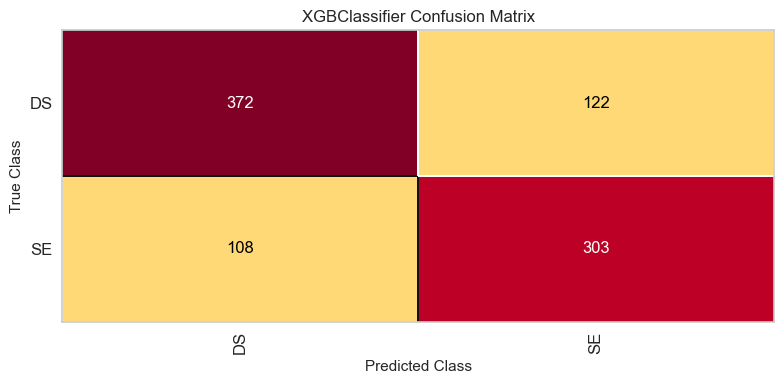

ConfusionMatrix(ax=<Axes: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=['DS', 'SE'],
                cmap=<matplotlib.colors.ListedColormap object at 0x28a0f1790>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_roun...
                                        gamma=None, gpu_id=None,
                                        grow_policy=None, importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=100, n_jobs=None,
                                        num_parallel_tree=None, predictor=None,
                                        random_state=None, ...))

In [12]:
fig, ax = plt.subplots(figsize = (8, 4))
classifier.confusion_matrix(xgb_def, X_train, y_train,
                            X_test, y_test,
                            classes=['DS', 'SE'], ax = ax
                            )

sklearn으로도 실행가능

In [13]:
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, xgb_def.predict(X_test))
cm

array([[372, 122],
       [108, 303]])

sklearn에서는 matplotlib을 불러와서 매트릭스를 플로팅할 수도 있다.

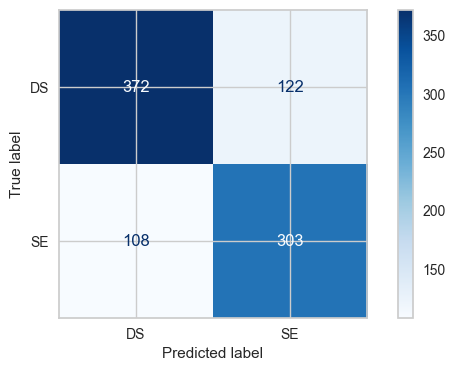

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=['DS', 'SE'])
disp.plot(ax=ax, cmap='Blues')

normalize 설정을 하면 다음과 같은 결과를 보인다.(유용할 듯)

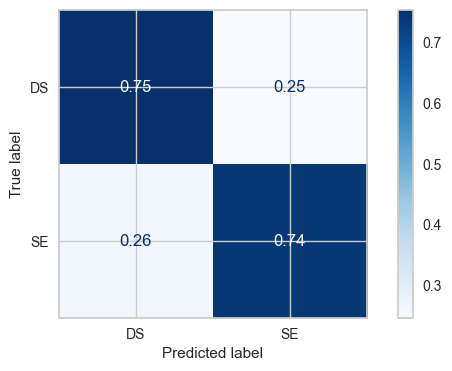

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))
cm = metrics.confusion_matrix(y_test, xgb_def.predict(X_test),
normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=['DS', 'SE'])
disp.plot(ax=ax, cmap='Blues')

### 15.3 Precision and Recall

In [16]:
metrics.precision_score(y_test, xgb_def.predict(X_test))

0.7129411764705882

In [17]:
metrics.recall_score(y_test, xgb_def.predict(X_test))

0.7372262773722628

두 메트릭의 트레이드 오프를 확인하기 위해 precision-recall 커브를 그려보자.

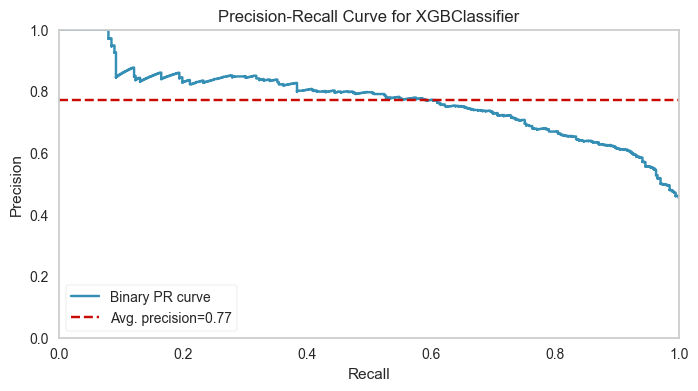

(0.0, 1.05)

In [18]:
from yellowbrick import classifier

fig, ax = plt.subplots(figsize=(8, 4))
classifier.precision_recall_curve(xgb_def, X_train, y_train,
X_test, y_test, micro=False, macro=False, ax=ax, per_class=True)
ax.set_ylim((0,1.05))

### 15.4 F1 Score

In [19]:

metrics.f1_score(y_test, xgb_def.predict(X_test))

0.7248803827751197

전체 리포트를 출력하는 기능도 있다.

In [20]:
print(metrics.classification_report(y_test,
                                    y_pred=xgb_def.predict(X_test), target_names=['DS', 'SE']))

              precision    recall  f1-score   support

          DS       0.78      0.75      0.76       494
          SE       0.71      0.74      0.72       411

    accuracy                           0.75       905
   macro avg       0.74      0.75      0.74       905
weighted avg       0.75      0.75      0.75       905



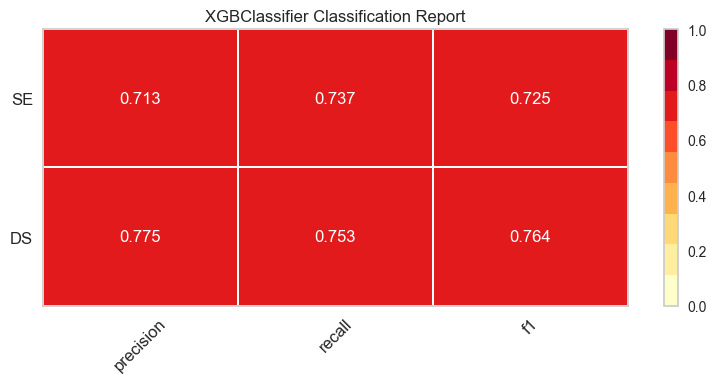

ClassificationReport(ax=<Axes: title={'center': 'XGBClassifier Classification Report'}>,
                     classes=['DS', 'SE'],
                     cmap=<matplotlib.colors.ListedColormap object at 0x28bb5d880>,
                     estimator=XGBClassifier(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,...
                                             gpu_id=None, grow_policy=None,
                                             importance_type=None,
                                             interaction_constraints=None,
                                             learning_rate=None, max_bin=None,
                                             max_cat_threshold=None,
                                             max_cat_to_onehot=None,
                                             max_delta_step=None,
                                             max_depth=None, max_leaves=None,
                                             min_child_weight=None, missing=nan,
                                             monotone_constraints=None,
                                             n_estimators=100, n_jobs=None,
                                             num_parallel_tree=None,
                                             predictor=None, random_state=None, ...))

In [21]:
fig, ax = plt.subplots(figsize=(8, 4))
classifier.classification_report(xgb_def, X_train, y_train,
X_test, y_test, classes=['DS', 'SE'],
micro=False, macro=False, ax=ax)

우선 앞에서 만든 모델을 학습 시키자.

In [22]:
step_params = {'random_state': 42,
 'max_depth': 5,
 'min_child_weight': 0.6411044640540848,
 'subsample': 0.9492383155577023,
 'colsample_bytree': 0.6235721099295888,
 'gamma': 0.00011273797329538491,
 'learning_rate': 0.24399020050740935}
xg_step = xgb.XGBClassifier(**step_params, early_stopping_rounds=50,
                            n_estimators=500)
xg_step.fit(X_train, y_train,
       eval_set=[(X_train, y_train),
                 (X_test, y_test)
                ],
        verbose=100
      )

[0]	validation_0-logloss:0.64342	validation_1-logloss:0.64282
[85]	validation_0-logloss:0.36150	validation_1-logloss:0.51357


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6235721099295888, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.00011273797329538491, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.24399020050740935, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=0.6411044640540848, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

그 다음 모델 성능이 얼마나 개선되었는지 보자.

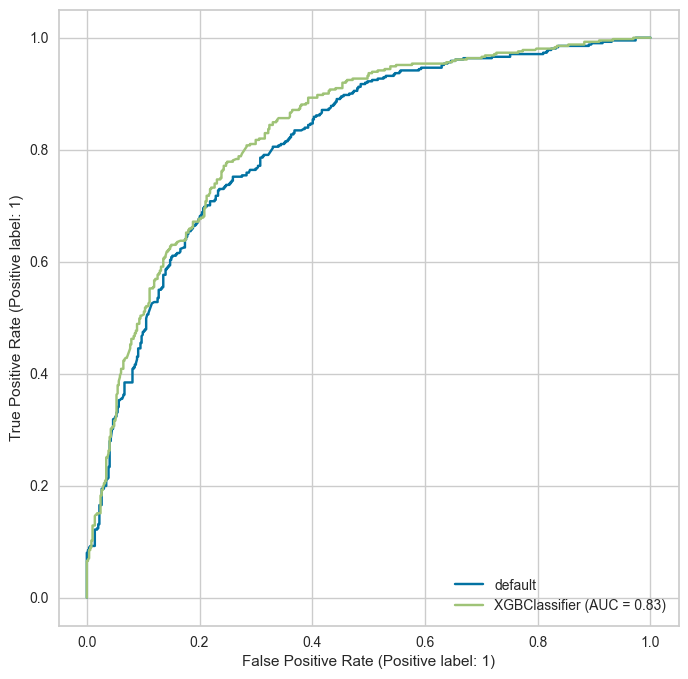

In [23]:
fig, ax = plt.subplots(figsize=(8,8))
metrics.RocCurveDisplay.from_estimator(xgb_def,
X_test, y_test,ax=ax, label='default')
metrics.RocCurveDisplay.from_estimator(xg_step,
X_test, y_test,ax=ax)

[Text(0.5, 1.0, 'ROC plots for stepwise model')]

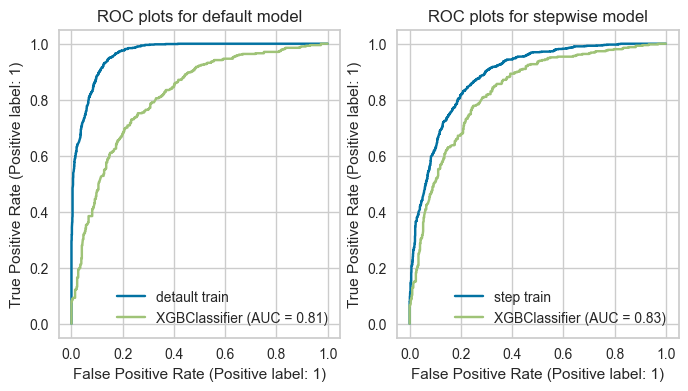

In [24]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)
metrics.RocCurveDisplay.from_estimator(xgb_def,
X_train, y_train,ax=axes[0], label='detault train')
metrics.RocCurveDisplay.from_estimator(xgb_def,
X_test, y_test,ax=axes[0])
axes[0].set(title='ROC plots for default model')
metrics.RocCurveDisplay.from_estimator(xg_step,
X_train, y_train,ax=axes[1], label='step train')
metrics.RocCurveDisplay.from_estimator(xg_step,
X_test, y_test,ax=axes[1])
axes[1].set(title='ROC plots for stepwise model')

### 15.6 Threshold Metrics

sklearn이나 xgboost는 threshold를 하이퍼파라미터로 노출하지 않는다.  
따라서 서브 클래스로 구현해야 한다.

In [25]:
class ThresholdXGBClassifier(xgb.XGBClassifier):
    def __init__(self, threshold = 0.5, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold
        
    def predict(self, X, *args, **kwargs):
        proba = self.predict_proba(X, *args, **kwargs)
        return (proba[:, 1] > self.threshold).astype(int)

In [26]:
xgb_def = xgb.XGBClassifier()
xgb_def.fit(X_train, y_train)
xgb_def.predict_proba(X_test.iloc[[0]])

array([[0.14253652, 0.8574635 ]], dtype=float32)

In [27]:
xgb_def.predict(X_test.iloc[[0]])

array([1])

In [28]:
xgb90 = ThresholdXGBClassifier(threshold=.9, verbosity=0)
xgb90.fit(X_train, y_train)
xgb90.predict(X_test.iloc[[0]])

array([0])

In [29]:
def get_tpr_fpr(probs, y_truth):
    """
    Calculates true positive rate (TPR) and false positive rate
    (FPR) given predicted probabilities and ground truth labels.

    Parameters:
    probs (np.array): predicted probabilities of positive class
    y_truth (np.array): ground truth labels

    Returns:
    tuple: (tpr, fpr)
    """
    tp = (probs == 1) & (y_truth == 1)
    tn = (probs < 1) & (y_truth == 0)
    fp = (probs == 1) & (y_truth == 0)
    fn = (probs < 1) & (y_truth == 1)
    tpr = tp.sum() / (tp.sum() + fn.sum())
    fpr = fp.sum() / (fp.sum() + tn.sum())
    return tpr, fpr

<Axes: title={'center': 'Threshold Metrics'}, xlabel='thresh'>

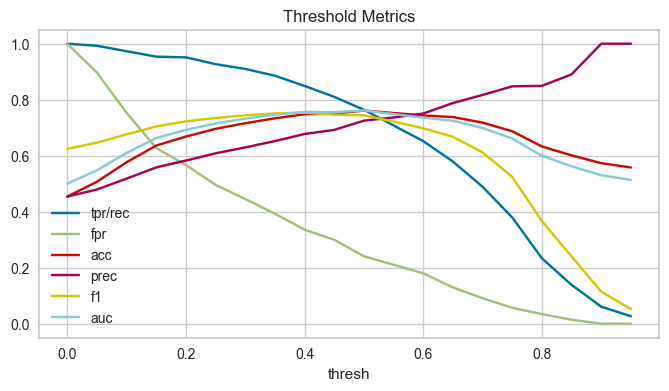

In [30]:
vals = []
for thresh in np.arange(0, 1, step=.05):
    probs = xg_step.predict_proba(X_test)[:, 1]
    tpr, fpr = get_tpr_fpr(probs > thresh, y_test)
    val = [thresh, tpr, fpr]
    for metric in [metrics.accuracy_score, metrics.precision_score,
                   metrics.recall_score, metrics.f1_score, 
                   metrics.roc_auc_score]:
        val.append(metric(y_test, probs > thresh))
    vals.append(val)
fig, ax = plt.subplots(figsize=(8, 4))
(pd.DataFrame(vals, columns=['thresh', 'tpr/rec', 'fpr', 'acc', 
                             'prec', 'rec', 'f1', 'auc'])
 .drop(columns='rec')
 .set_index('thresh')
 .plot(ax=ax, title='Threshold Metrics')
)

### 15.7 Cumulative Gains Curve

이 곡선은 리소스가 한정되어 있는 상황에서 모델을 평가할 때 효과적이다....  

This curve is useful for maximizing marketing response rates (evaluating a model when you have finite resources). It plots the gain (the recall or sensitivity) against the ordered samples. 

The baseline is what a random prediction would give you. The gain is calculated as the true positive rate if you were to order the predictions by the probability against the percentage of samples.

Look at the plot below from the scikitplot library. I have augmented it to show the optimal gains (what a perfect model would give you).

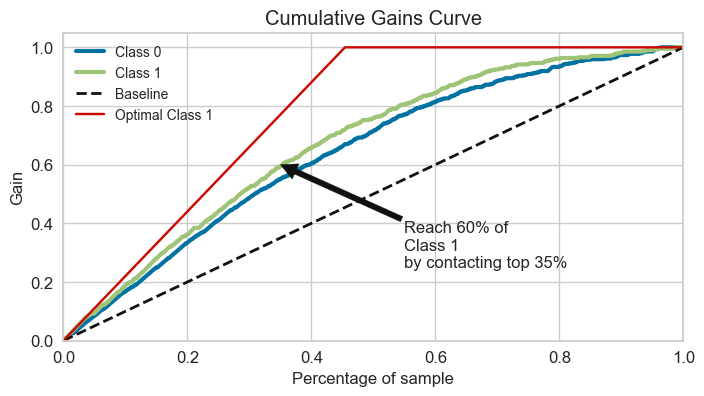

In [31]:
import scikitplot
fig, ax = plt.subplots(figsize=(8, 4))
y_probs = xgb_def.predict_proba(X_test)
scikitplot.metrics.plot_cumulative_gain(y_test, y_probs, ax=ax)
ax.plot([0, (y_test == 1).mean(), 1], [0, 1, 1], label='Optimal Class 1')
ax.set_ylim(0, 1.05)
ax.annotate('Reach 60% of\nClass 1\nby contacting top 35%', xy=(.35, .6),
           xytext=(.55,.25), arrowprops={'color':'k'})
ax.legend()


### 15.8 Lift Curves

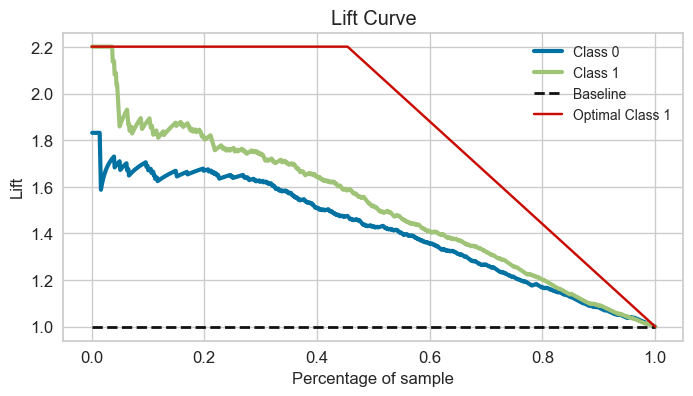

In [32]:
fig, ax = plt.subplots(figsize=(8, 4))
y_probs = xgb_def.predict_proba(X_test)
scikitplot.metrics.plot_lift_curve(y_test, y_probs, ax=ax)
mean = (y_test == 1).mean()
ax.plot([0, mean, 1], [1/mean, 1/mean, 1], label='Optimal Class 1')
ax.legend()